# ***LGBM***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# IMPORTS
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import random

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import lime.lime_tabular
import time

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import lightgbm as lgb

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_lgb_model.pkl"
study_filename = "../Study/optuna_study_LGB_nested.pkl"
metrics_filename = "../Models/best_lgb_metrics.pkl"
fold_metrics_filename = "./Metrics/lgb_folds_summary.csv"

In [4]:
# WRAPPER CLASS FOR LIGHTGBM
class LGBMWrapper:
    def __init__(self, params, numeric_features, categorical_features):
        self.params = params.copy()
        self.num_boost_round = self.params.pop("num_boost_round")
        self.early_stopping_rounds = self.params.pop("early_stopping_rounds", None)
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()
        self.model = None
        self.evals_result = None
        self.best_iteration = None
        self.best_score = None

    def _build_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='median'), self.numeric_features),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), self.categorical_features)
            ],
            verbose_feature_names_out=False,
            force_int_remainder_cols=False
        )


    def fit(self, X, y, eval_set=None, sample_weight=None):
        self.preprocessor = self._build_preprocessor().fit(X)
        X_proc = self.preprocessor.transform(X)

        dtrain = lgb.Dataset(X_proc, label=y, weight=sample_weight)

        valid_sets = [dtrain]
        valid_names = ["train"]

        evals_result = {}

        if eval_set is not None:
            X_val, y_val = eval_set[0]
            X_val_proc = self.preprocessor.transform(X_val)
            dval = lgb.Dataset(X_val_proc, label=y_val)
            valid_sets.append(dval)
            valid_names.append("validation")

        callbacks = [lgb.record_evaluation(evals_result)]

        if self.early_stopping_rounds is not None and len(valid_sets) > 1:
            callbacks.append(lgb.early_stopping(self.early_stopping_rounds, verbose=False))

        self.model = lgb.train(
            self.params,
            dtrain,
            num_boost_round=self.num_boost_round,
            valid_sets=valid_sets,
            valid_names=valid_names,
            callbacks=callbacks
        )

        self.evals_result = evals_result
        self.best_iteration = getattr(self.model, "best_iteration", None)
        self.best_score = self.model.best_score.get("valid_1", {}).get("multi_logloss", None)
        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        y_proba = self.model.predict(X_proc)
        return np.argmax(y_proba, axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def save(self, path):
        joblib.dump({
            "params": self.params,
            "num_boost_round": self.num_boost_round,
            "early_stopping_rounds": self.early_stopping_rounds,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
            "booster": self.model,
            "best_iteration": self.best_iteration,
            "best_score": self.best_score
        }, path)

    @classmethod
    def load(cls, path):
        data = joblib.load(path)
        params = {**data["params"], "num_boost_round": data["num_boost_round"]}

        if "early_stopping_rounds" in data:
            params["early_stopping_rounds"] = data["early_stopping_rounds"]

        wrapper = cls(
            params,
            data["numeric_features"],
            data["categorical_features"]
        )
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = data["booster"]
        wrapper.best_iteration = data.get("best_iteration")
        wrapper.best_score = data.get("best_score")
        return wrapper


In [5]:
# OPTUNA INNER CV OPTIMIZATION
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "verbosity": -1,
            "objective": "multiclass",
            "num_class": len(np.unique(y_inner)),
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            "metric": "multi_logloss",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),      
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 80),                    
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.9),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),       
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 150),         
            "early_stopping_rounds": 10,
            "max_depth": -1,        
            "device_type": "gpu",   
            "seed": SEED
        }

        # Parameters for DART
        if params["boosting_type"] == "dart":
            params["drop_rate"] = trial.suggest_float("drop_rate", 0.1, 0.3)
            params["skip_drop"] = trial.suggest_float("skip_drop", 0.1, 0.7)
            params["max_drop"] = trial.suggest_int("max_drop", 10, 40)
            params["early_stopping_rounds"] = None  

        model = LGBMWrapper(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]

            sample_weights = compute_sample_weight("balanced", y_t)
            eval_set = [(X_v, y_v)]

            model.fit(X_t, y_t, eval_set=eval_set, sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=10)

    return study.best_params, study


In [6]:
# NESTED CV
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        best_params["objective"] = "multiclass"
        best_params["num_class"] = 3
        best_params["metric"] = "multi_logloss"
        best_params["seed"] = SEED

        model = LGBMWrapper(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [7]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3426
           1       0.81      0.73      0.77      1034
           2       0.82      0.71      0.76       625

    accuracy                           0.89      5085
   macro avg       0.85      0.80      0.82      5085
weighted avg       0.88      0.89      0.88      5085



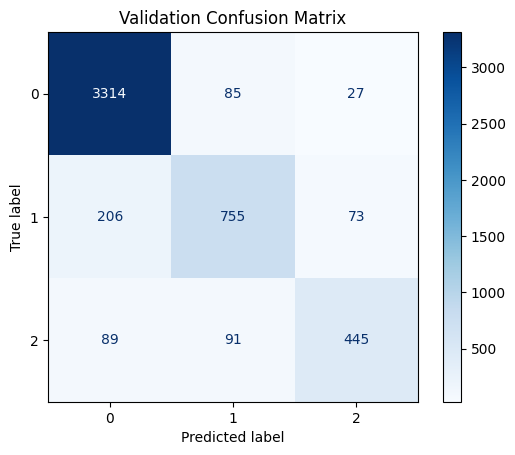

In [9]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [10]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4282
           1       0.80      0.74      0.77      1292
           2       0.83      0.67      0.74       781

    accuracy                           0.89      6355
   macro avg       0.85      0.79      0.82      6355
weighted avg       0.88      0.89      0.88      6355



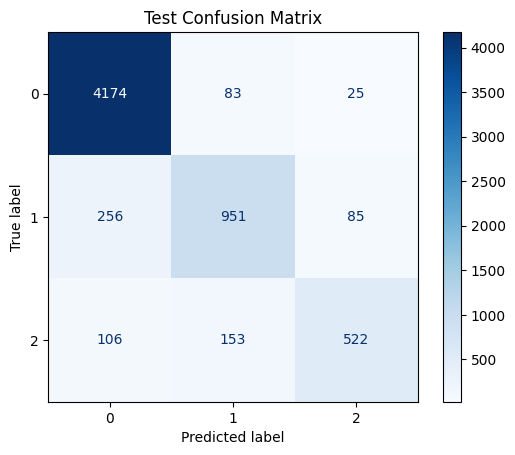

In [11]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

In [12]:
def plot_loss_curves(model):
    """
    Plots the training loss curves (logloss or any metric) for train/validation sets.
    Handles both LightGBM and XGBoost formats.
    """
    if not hasattr(model, "evals_result") or model.evals_result is None:
        raise ValueError("The model has no evaluation history.")

    results = None

    if hasattr(model.model, 'evals_result_'):  
        results = model.model.evals_result_
    elif isinstance(model.evals_result, dict): 
        results = model.evals_result
    else:
        raise TypeError(f"Unexpected evals_result type: {type(model.evals_result)}")

    for dataset, metrics in results.items():
        for metric_name, values in metrics.items():
            plt.plot(values, label=f"{dataset} {metric_name}")

    plt.xlabel("Boosting round")
    plt.ylabel("Metric value")
    plt.title("Training Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

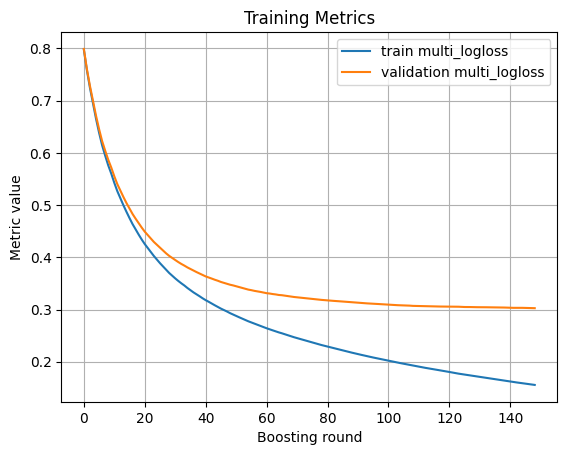

In [13]:
plot_loss_curves(model)

--- Explanation for class 0 ---


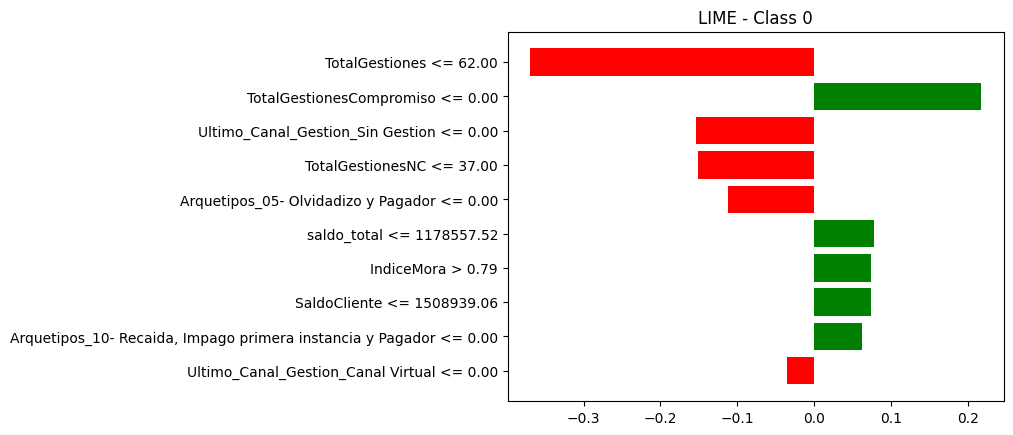

--- Explanation for class 1 ---


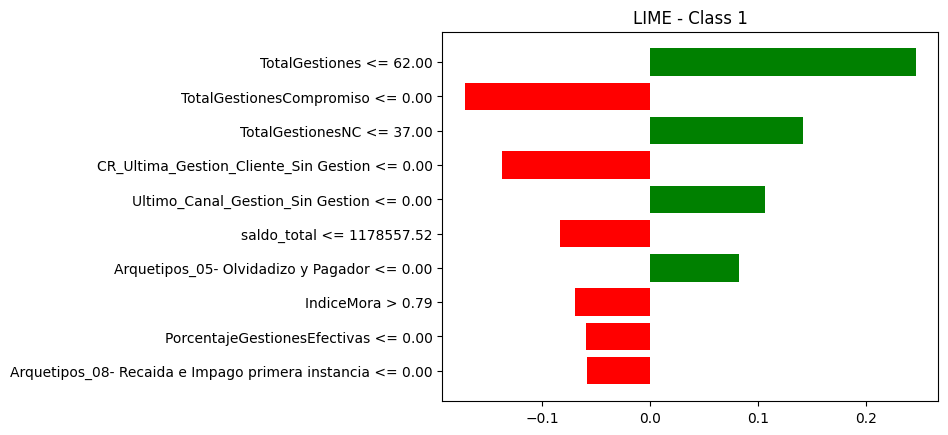

--- Explanation for class 2 ---


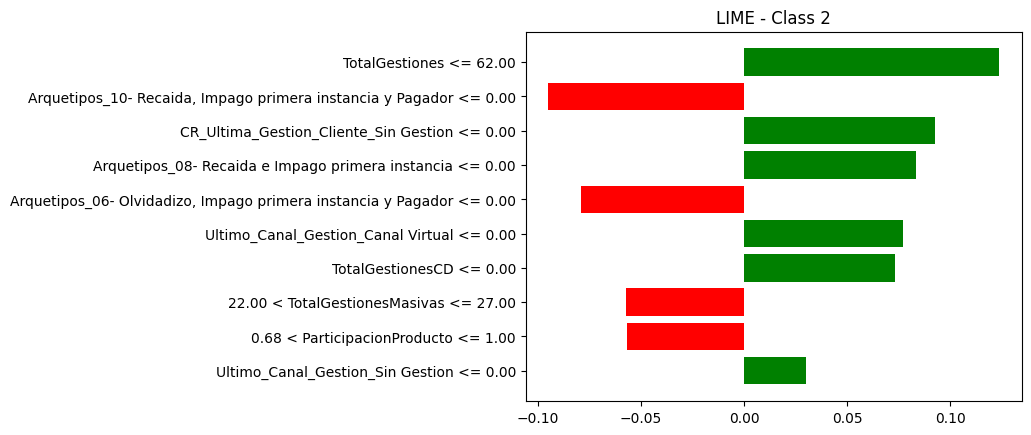

In [14]:
X_transformed = model.preprocessor.transform(metrics['X_train_fold'])

def predict_fn(x):
    return model.model.predict(x)  

feature_names = model.preprocessor.get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance = X_transformed[180]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [15]:
visualizations['optimization_history']

In [17]:
visualizations['f1_score_evolution']

In [18]:
visualizations['param_importances']

In [19]:
# Get raw importances by gain
importances = model.model.feature_importance(importance_type='gain')

# Get feature names from preprocessor
feature_names = model.preprocessor.get_feature_names_out()

# Map feature names to importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
fig = px.bar(
    importance_df,
    x='Feature',
    y='Importance',
    title='Top 20 Feature Importance - LGBM',
    labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
    color='Importance',
    color_continuous_scale='Viridis',
    text='Importance'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [20]:
reporte.save(metrics, model_name="LGBM")


Report for model 'LGBM' saved:
   → CSV: ./Metrics/Metrics_LGBM.csv
   → JSON: ./Metrics/Metrics_LGBM.json


In [21]:
df = reporte.load()


Loaded 8 report(s)


In [22]:
df.query("Model == 'LGBM' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
42,LGBM,val,0,0.918,0.967,0.942
43,LGBM,val,1,0.811,0.73,0.768
44,LGBM,val,2,0.817,0.712,0.761
45,LGBM,val,macro avg,0.849,0.803,0.824
46,LGBM,val,weighted avg,0.884,0.888,0.885


In [23]:
df.query("Model == 'LGBM' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
48,LGBM,test,0,0.92,0.975,0.947
49,LGBM,test,1,0.801,0.736,0.767
50,LGBM,test,2,0.826,0.668,0.739
51,LGBM,test,macro avg,0.849,0.793,0.818
52,LGBM,test,weighted avg,0.884,0.889,0.885


In [ ]:
df.query("Model == 'LGBM' and auc != '-' and Type != 'train'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
41,LGBM,train,0.956,0.156,0.995
47,LGBM,val,0.888,0.303,0.964
53,LGBM,test,0.889,0.297,0.968


In [25]:
df.query("Model == 'LGBM' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
47,LGBM,val,0.888,0.303,0.964


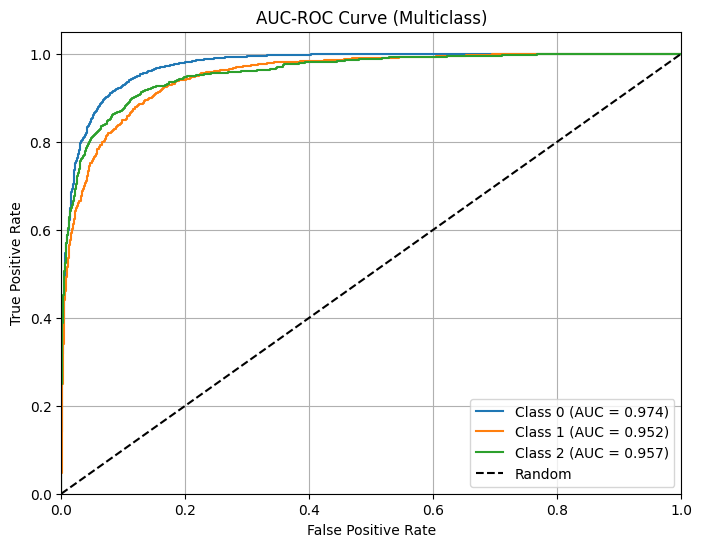

In [26]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"]
)

In [27]:
model.params  

{'boosting_type': 'gbdt',
 'lambda_l1': 0.18911524586388437,
 'lambda_l2': 0.011243537464614489,
 'num_leaves': 58,
 'feature_fraction': 0.6766174807365394,
 'bagging_fraction': 0.7486675199988826,
 'bagging_freq': 3,
 'min_child_samples': 11,
 'learning_rate': 0.045493260265052446,
 'objective': 'multiclass',
 'num_class': 3,
 'metric': 'multi_logloss',
 'seed': 42}